In [1]:
%matplotlib inline

import collections
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn import grid_search
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC

In [2]:
# 2014-02-03T19:24:07Z
def parse_time(time):
    return datetime.datetime.strptime(time, '%Y-%m-%dT%H:%M:%SZ')

In [3]:
SECONDS_PER_DAY = 60 * 60 * 24
def days_between(start_date, end_date):
    return (parse_time(end_date) - parse_time(start_date)).total_seconds() / SECONDS_PER_DAY

In [4]:
print days_between('2014-01-03T19:24:07Z', '2014-02-03T19:24:07Z')

31.0


## Import Metadata

In [5]:
class_upper_bounds = [30, 60, 120, 365, float('inf')]
NUM_CLASSES = len(class_upper_bounds)
class_buckets = collections.defaultdict(list)

selected_metadata = os.path.join('data', 'selected_metadata.txt')

meta_days_between = []

header = True
for line in open(selected_metadata):
    if header:
        header = False
        continue
    parts = line.strip().split()
    doc_id = parts[0]
    between = days_between(parts[2], parts[3])
    meta_days_between.append(between)
    
    for class_label, upper_bound in enumerate(class_upper_bounds):
        if between <= upper_bound:
            class_buckets[class_label].append( (doc_id, parts[2], parts[3]) )
            break
    
meta_days_between = [m for m in meta_days_between if m >= 0]
print len(meta_days_between)

108966


(array([  8.06830000e+04,   1.03880000e+04,   6.01400000e+03,
          3.86200000e+03,   2.31600000e+03,   1.56100000e+03,
          1.10500000e+03,   8.14000000e+02,   6.02000000e+02,
          3.66000000e+02,   3.16000000e+02,   1.78000000e+02,
          1.25000000e+02,   9.70000000e+01,   9.30000000e+01,
          7.80000000e+01,   5.70000000e+01,   6.20000000e+01,
          6.30000000e+01,   4.70000000e+01,   2.20000000e+01,
          1.80000000e+01,   1.30000000e+01,   7.00000000e+00,
          1.20000000e+01,   5.00000000e+00,   9.00000000e+00,
          9.00000000e+00,   3.00000000e+00,   9.00000000e+00,
          6.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

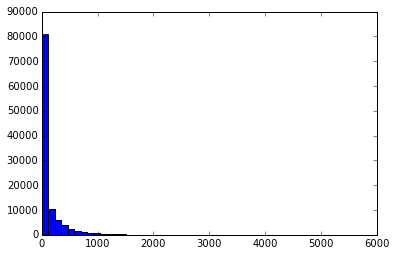

In [6]:
plt.hist(meta_days_between, bins = 50)

In [7]:
total = 0
for i in range(NUM_CLASSES):
    total += len(class_buckets[i])
    print i, len(class_buckets[i])
print 'Total:', total

0 66055
1 6774
2 8615
3 16607
4 11233
Total: 109284


## Import READMEs

In [8]:
readmes = []
classes = []

counter = 0

for c in range(NUM_CLASSES):
    for entry in class_buckets[c]:
        if parse_time(entry[1]).year != 2015:
            readme_path = os.path.join('data', 'clean', str(int(entry[0])/1000000) , entry[0] + '.md')
            try: # Some READMEs may have had no content after being cleaned.
                readme = ' '.join(open(readme_path).readlines())
                readmes.append( readme )
                classes.append(c)
            except:
                pass
        
        counter += 1
        if counter % 10000 == 0:
            print 'Progress:', counter

print 'Number of valid READMEs', len(readmes)

Progress: 10000
Progress: 20000
Progress: 30000
Progress: 40000
Progress: 50000
Progress: 60000
Progress: 70000
Progress: 80000
Progress: 90000
Progress: 100000
Number of valid READMEs 95000


In [23]:
vectorizer = CountVectorizer(ngram_range=(1,2))  # for  unigrams only use ngram_range=(1, 1)
readme_term_matrix = vectorizer.fit_transform(readmes)

In [26]:
matrix_train, matrix_test, classes_train, classes_test = \
    train_test_split(readme_term_matrix, classes, test_size=0.80, random_state=42)

## Estimator Using Only Text

In [27]:
parameter_grid = dict(
    estimator__C=[1e-2, 1e-1, 1, 1e1, 1e2],  # you can also build this using np.logspace
    estimator__class_weight=['auto', None])

clf = grid_search.GridSearchCV(OneVsRestClassifier(LinearSVC()), parameter_grid, cv=3, verbose=True)

In [28]:
clf.fit(matrix_train, classes_train) 

C:\Users\Joshua\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function multilabel_ is deprecated; Attribute multilabel_ is deprecated and will be removed in 0.17. Use 'y_type_.startswith('multilabel')' instead
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  2.6min
C:\Users\Joshua\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function multilabel_ is deprecated; Attribute multilabel_ is deprecated and will be removed in 0.17. Use 'y_type_.startswith('multilabel')' instead
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Joshua\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function multilabel_ is deprecated; Attribute multilabel_ is deprecated and will be removed in 0.17. Use 'y_type_.startswith('multilabel')' instead
  warnings.warn(msg, category=DeprecationWar

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
       estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0),
          n_jobs=1),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'estimator__class_weight': ['auto', None], 'estimator__C': [0.01, 0.1, 1, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=True)

In [29]:
predictions = clf.predict(matrix_test)

In [30]:
predictions_list = list(predictions)

In [31]:
print len(predictions), len(classes_test)

76000 76000


In [36]:
errors = 0

class_errors = collections.defaultdict(int)

for actual, pred in zip(classes_test, predictions_list):
    if actual != pred:
        errors += 1
        class_errors[actual] += 1
        
print 'Number of errors:', errors
print 'Error Percentage', errors * 100.0 / len(predictions_list) , '%'

print '====='
for c in range(NUM_CLASSES):
    print c, class_errors[c], class_errors[c] * 100.0 / list(classes_test).count(c)

Number of errors: 35350
Error Percentage 46.5131578947 %
=====
0 6018 13.8227254979
1 3961 98.166047088
2 5941 96.0084033613
3 11568 86.990524891
4 7862 87.9221650637


## Estimator Using Google Trends

## Predict Latest Commit Date

In [4]:
class_buckets = collections.defaultdict(list)

selected_metadata = os.path.join('data', 'selected_metadata.txt')

header = True
for line in open(selected_metadata):
    if header:
        header = False
        continue
    parts = line.strip().split()
    doc_id = parts[0]
    latest_commit = parse_time(parts[3])

    class_buckets[latest_commit.year].append(doc_id)

In [5]:
for k in class_buckets:
    if k > 2007:
        print k, len(class_buckets[k])

2008 611
2009 1829
2010 853
2011 4198
2012 9254
2013 18468
2014 45341
2015 28692


In [6]:
readmes = []
classes = []

counter = 0

for k in class_buckets:
    if k > 2007:
        for entry in class_buckets[k]:
            readme_path = os.path.join('data', 'clean', str(int(entry)/1000000) , entry + '.md')
            try: # Some READMEs may have had no content after being cleaned.
                readme = ' '.join(open(readme_path).readlines())
                readmes.append( readme )
                classes.append(k)
            except:
                pass
        
            counter += 1
            if counter % 10000 == 0:
                print 'Progress:', counter

print 'Number of valid READMEs', len(readmes)

Number of valid READMEs 109134


In [7]:
vectorizer = CountVectorizer(ngram_range=(1,2))  # for  unigrams only use ngram_range=(1, 1)
readme_term_matrix = vectorizer.fit_transform(readmes)

In [14]:
matrix_train, matrix_test, classes_train, classes_test = \
    train_test_split(readme_term_matrix, classes, test_size=0.20, random_state=42)

In [ ]:
#clf = MultinomialNB()
clf = LinearSVC()
clf.fit(matrix_train, classes_train)

In [ ]:
multi_nb_predictions = clf.predict(matrix_test)

In [ ]:
print len(multi_nb_predictions), len(classes_test)

In [ ]:
errors = 0

class_errors = collections.defaultdict(int)

for actual, pred in zip(classes_test, multi_nb_predictions):
    if actual != pred:
        errors += 1
        class_errors[actual] += 1
        
print 'Number of errors:', errors
print 'Error Percentage', errors * 100.0 / len(multi_nb_predictions) , '%'

print '====='
for c in class_errors:
    print c, class_errors[c], class_errors[c] * 100.0 / list(classes_test).count(c)